In [1]:
from google.cloud import bigquery
from google.cloud import bigquery_storage
creds = "/Users/srdeo/OneDrive - Copart, Inc/secrets/cprtpr-datastewards-sp1-614d7e297848 (1).json"
client = bigquery.Client.from_service_account_json(json_credentials_path=creds)
bqstorageclient = bigquery_storage.BigQueryReadClient(credentials=creds)
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [2]:
import pandas as pd

In [3]:
import warnings
import numpy as np
import pandas as pd

warnings.filterwarnings("ignore")

### Extracting Churn Members and Non Churn Members for April 2025

In [4]:
query = f"""
    SELECT
        m.owner_mbr_nbr,
        m.mbr_nbr,
        m.mbr_type,
        m.mbr_mbrshp_type_cd,
        e.event_type,
        e.event_value,
        DATE_TRUNC(e.event_value, MONTH) AS event_month,
        'April' AS month_label,
        CASE
            WHEN m.mbr_type = 'LPSDPREMIER' AND e.event_type = 'MEMBER TYPE UPDATED FROM PREMIER TO GUEST' THEN 1
            WHEN m.mbr_type = 'PREMIER' AND e.event_type = 'Member Premier Renewal Paid Date' THEN 0
            ELSE NULL
        END AS churn
    FROM `cprtpr-dataplatform-sp1`.usviews.v_us_member_fact m
    JOIN `cprtpr-dataplatform-sp1`.usmart.v_us_member_events_fact e
        ON m.mbr_nbr = e.mbr_nbr
    WHERE (
        (m.mbr_type = 'PREMIER' AND e.event_type = 'Member Premier Renewal Paid Date') OR
        (m.mbr_type = 'LPSDPREMIER' AND e.event_type = 'MEMBER TYPE UPDATED FROM PREMIER TO GUEST')
    )
      AND e.event_value BETWEEN '2025-04-01' AND '2025-04-30'
      """

data1 = client.query(query).to_dataframe()

In [5]:
data1
print(data1.shape)
print(data1.isnull().sum())
print(data1['churn'].value_counts())

,owner_mbr_nbr,mbr_nbr,mbr_type,mbr_mbrshp_type_cd,event_type,event_value,event_month,month_label,churn
0,741824,741824,PREMIER,PREMIER,Member Premier Renewal Paid Date,2025-04-14 08:05:53+00:00,2025-04-01 00:00:00+00:00,April,0
1,742561,742561,PREMIER,PREMIER,Member Premier Renewal Paid Date,2025-04-10 15:24:23+00:00,2025-04-01 00:00:00+00:00,April,0
2,107874,107874,PREMIER,PREMIER,Member Premier Renewal Paid Date,2025-04-08 15:54:09+00:00,2025-04-01 00:00:00+00:00,April,0
3,743985,743985,PREMIER,PREMIER,Member Premier Renewal Paid Date,2025-04-09 20:36:15+00:00,2025-04-01 00:00:00+00:00,April,0
4,186735,186735,PREMIER,PREMIER,Member Premier Renewal Paid Date,2025-04-02 08:03:38+00:00,2025-04-01 00:00:00+00:00,April,0
...,...,...,...,...,...,...,...,...,...
6383,371662,371662,LPSDPREMIER,GUEST,MEMBER TYPE UPDATED FROM PREMIER TO GUEST,2025-04-06 10:00:12+00:00,2025-04-01 00:00:00+00:00,April,1
6384,553820,553820,LPSDPREMIER,GUEST,MEMBER TYPE UPDATED FROM PREMIER TO GUEST,2025-04-19 10:00:08+00:00,2025-04-01 00:00:00+00:00,April,1
6385,368521,368521,LPSDPREMIER,GUEST,MEMBER TYPE UPDATED FROM PREMIER TO GUEST,2025-04-20 10:00:07+00:00,2025-04-01 00:00:00+00:00,April,1
6386,372862,372862,LPSDPREMIER,GUEST,MEMBER TYPE UPDATED FROM PREMIER TO GUEST,2025-04-20 10:00:08+00:00,2025-04-01 00:00:00+00:00,April,1


(6388, 9)
owner_mbr_nbr         0
mbr_nbr               0
mbr_type              0
mbr_mbrshp_type_cd    0
event_type            0
event_value           0
event_month           0
month_label           0
churn                 0
dtype: int64
churn
1    3955
0    2433
Name: count, dtype: Int64


* Below query extracts unique owner mbr from above and converts into SQL IN clause format

In [6]:
owner_ids = data1['owner_mbr_nbr'].unique().tolist()
owner_ids_str = ", ".join([str(x) for x in owner_ids])

In [7]:
churn_list = data1[data1['churn'] == 1]['owner_mbr_nbr'].unique().tolist()

In [8]:
len(owner_ids)

6370

* Below query extracts PMs (churn /non-churn in April) and their data between oct 2024 - mar 2025 excluding CDS

In [9]:
query2 = f"""
WITH cds_members AS (
  SELECT DISTINCT buyer_nbr
  FROM `cprtpr-dataplatform-sp1`.usviews.v_us_lot_fact
  WHERE inv_dt BETWEEN '2024-10-01' AND '2025-03-31'
    AND seller_parent_company = 'CDS'
),

lot_fact_filtered AS (
  SELECT
    lot_nbr,
    inv_dt,
    seller_parent_company,
    high_bid_amt,
    buyer_nbr
  FROM `cprtpr-dataplatform-sp1`.usviews.v_us_lot_fact
  WHERE inv_dt BETWEEN '2024-10-01' AND '2025-03-31'
    AND seller_parent_company != 'CDS'
),

member_info AS (
  SELECT
    owner_mbr_nbr,
    mbr_nbr,
    mbr_state,
    mbr_country,
    member_sgmnt_type
  FROM `cprtpr-dataplatform-sp1`.usviews.v_us_member_fact
  WHERE owner_mbr_nbr IN ({owner_ids_str})
),

bids_placed AS (
  SELECT
    m.owner_mbr_nbr,
    m.mbr_nbr,
    m.mbr_state,
    m.mbr_country,
    m.member_sgmnt_type,
    AVG(CASE WHEN l.lot_nbr IS NOT NULL THEN b.bid_amt ELSE NULL END) AS avg_max_bid_amt,
    COUNTIF(l.inv_dt IS NOT NULL) AS total_bids_on_lots_sold
  FROM member_info m
  LEFT JOIN `cprtpr-dataplatform-sp1`.usviews.v_us_bids_fact b
    ON m.mbr_nbr = b.buyer_nbr
  LEFT JOIN lot_fact_filtered l
    ON b.lot_nbr = l.lot_nbr
  GROUP BY m.owner_mbr_nbr, m.mbr_nbr, m.mbr_state, m.mbr_country, m.member_sgmnt_type
),

lots_bid_on AS (
  SELECT
    b.buyer_nbr AS mbr_nbr,
    COUNT(DISTINCT b.lot_nbr) AS total_lots_placed_bids_on
  FROM `cprtpr-dataplatform-sp1`.usviews.v_us_bids_fact b
  JOIN lot_fact_filtered l
    ON b.lot_nbr = l.lot_nbr
  GROUP BY b.buyer_nbr
),

lots_won AS (
  SELECT
    l.buyer_nbr AS mbr_nbr,
    AVG(l.high_bid_amt) AS AvgSellingPrice,
    COUNT(DISTINCT l.lot_nbr) AS total_lots_won
  FROM lot_fact_filtered l
  GROUP BY l.buyer_nbr
)

SELECT
  bp.owner_mbr_nbr,
  bp.mbr_nbr,
  bp.total_bids_on_lots_sold,
  lb.total_lots_placed_bids_on,
  w.total_lots_won,
  bp.avg_max_bid_amt,
  w.AvgSellingPrice,
  bp.mbr_state,
  bp.mbr_country,
  bp.member_sgmnt_type
FROM bids_placed bp
LEFT JOIN lots_bid_on lb ON bp.mbr_nbr = lb.mbr_nbr
LEFT JOIN lots_won w ON bp.mbr_nbr = w.mbr_nbr
WHERE bp.mbr_nbr NOT IN (SELECT buyer_nbr FROM cds_members)
"""

data2 = client.query(query2).to_dataframe()

In [10]:
data2
print(data2.shape)
print(data2.isnull().sum())
print(data2['owner_mbr_nbr'].nunique())

,owner_mbr_nbr,mbr_nbr,total_bids_on_lots_sold,total_lots_placed_bids_on,total_lots_won,avg_max_bid_amt,AvgSellingPrice,mbr_state,mbr_country,member_sgmnt_type
0,415293,415293,0,<NA>,<NA>,NaN,NaN,NM,USA,Consumer
1,487918,487918,0,<NA>,<NA>,NaN,NaN,JL,MEX,Exporter
2,808661,808661,294,52,7,672.959184,1014.285714,MO,USA,Dealer
3,480874,480874,0,<NA>,<NA>,NaN,NaN,IL,USA,None
4,517908,517908,5,3,2,825.000000,1125.000000,SD,USA,Dealer
...,...,...,...,...,...,...,...,...,...,...
5327,281259,281259,86,37,5,520.755814,1000.000000,TX,USA,Consumer
5328,178442,178442,0,<NA>,<NA>,NaN,NaN,ND,USA,Consumer
5329,227266,227266,0,<NA>,<NA>,NaN,NaN,PA,USA,Consumer
5330,295531,295531,0,<NA>,<NA>,NaN,NaN,TX,USA,Consumer


(5332, 10)
owner_mbr_nbr                   0
mbr_nbr                         0
total_bids_on_lots_sold         0
total_lots_placed_bids_on    3144
total_lots_won               4074
avg_max_bid_amt              3144
AvgSellingPrice              4074
mbr_state                       0
mbr_country                     0
member_sgmnt_type             340
dtype: int64
5332


In [11]:
data2_copy = data2.copy()

In [12]:
data2_copy['total_lots_placed_bids_on'] = data2_copy['total_lots_placed_bids_on'].fillna(0)
data2_copy['total_lots_won'] = data2_copy['total_lots_won'].fillna(0)
data2_copy['avg_max_bid_amt'] = data2_copy['avg_max_bid_amt'].fillna(0)
data2_copy['AvgSellingPrice'] = data2_copy['AvgSellingPrice'].fillna(0)

In [13]:
data2_copy['churn'] = data2_copy['owner_mbr_nbr'].isin(churn_list).astype(int)

In [14]:
data2_copy

,owner_mbr_nbr,mbr_nbr,total_bids_on_lots_sold,total_lots_placed_bids_on,total_lots_won,avg_max_bid_amt,AvgSellingPrice,mbr_state,mbr_country,member_sgmnt_type,churn
0,415293,415293,0,0,0,0.000000,0.000000,NM,USA,Consumer,1
1,487918,487918,0,0,0,0.000000,0.000000,JL,MEX,Exporter,1
2,808661,808661,294,52,7,672.959184,1014.285714,MO,USA,Dealer,0
3,480874,480874,0,0,0,0.000000,0.000000,IL,USA,None,1
4,517908,517908,5,3,2,825.000000,1125.000000,SD,USA,Dealer,0
...,...,...,...,...,...,...,...,...,...,...,...
5327,281259,281259,86,37,5,520.755814,1000.000000,TX,USA,Consumer,1
5328,178442,178442,0,0,0,0.000000,0.000000,ND,USA,Consumer,1
5329,227266,227266,0,0,0,0.000000,0.000000,PA,USA,Consumer,1
5330,295531,295531,0,0,0,0.000000,0.000000,TX,USA,Consumer,1


In [15]:
data2_copy['churn'].value_counts()

churn
1    3757
0    1575
Name: count, dtype: int64

In [16]:
data2_copy['owner_mbr_nbr'].nunique()

5332

In [17]:
data2_copy['winning_perc'] = np.where(
    data2_copy['total_lots_placed_bids_on'] == 0,
    0,
    np.round(
        (data2_copy['total_lots_won'] / data2_copy['total_lots_placed_bids_on']) * 100, 2
    )
)

In [18]:
data2_copy

,owner_mbr_nbr,mbr_nbr,total_bids_on_lots_sold,total_lots_placed_bids_on,total_lots_won,avg_max_bid_amt,AvgSellingPrice,mbr_state,mbr_country,member_sgmnt_type,churn,winning_perc
0,415293,415293,0,0,0,0.000000,0.000000,NM,USA,Consumer,1,0.00
1,487918,487918,0,0,0,0.000000,0.000000,JL,MEX,Exporter,1,0.00
2,808661,808661,294,52,7,672.959184,1014.285714,MO,USA,Dealer,0,13.46
3,480874,480874,0,0,0,0.000000,0.000000,IL,USA,None,1,0.00
4,517908,517908,5,3,2,825.000000,1125.000000,SD,USA,Dealer,0,66.67
...,...,...,...,...,...,...,...,...,...,...,...,...
5327,281259,281259,86,37,5,520.755814,1000.000000,TX,USA,Consumer,1,13.51
5328,178442,178442,0,0,0,0.000000,0.000000,ND,USA,Consumer,1,0.00
5329,227266,227266,0,0,0,0.000000,0.000000,PA,USA,Consumer,1,0.00
5330,295531,295531,0,0,0,0.000000,0.000000,TX,USA,Consumer,1,0.00


<Axes: ylabel='Frequency'>

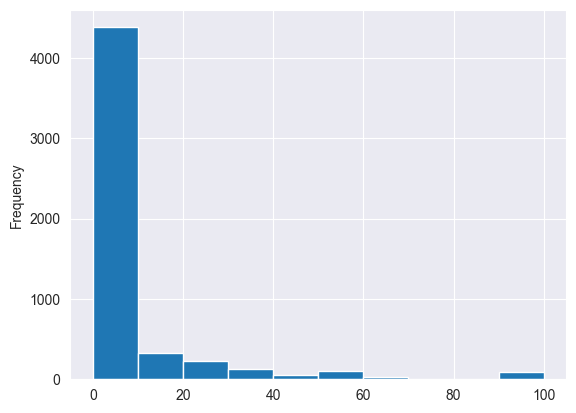

In [19]:
data2_copy['winning_perc'].plot(kind='hist')

In [25]:
data2_copy[data2_copy['total_bids_on_lots_sold'] == 0]['owner_mbr_nbr'].nunique()

3144

In [26]:
data2_copy[(data2_copy['total_lots_placed_bids_on'] > 0) & (data2_copy['total_lots_placed_bids_on'] <= 10)]['owner_mbr_nbr'].nunique()

1273

* 59% of the members who churned in April did not place any bids on the lots sold between Oct 2024 - Mar 2025.

### Extracting one user for analysis

In [20]:
filtered_df = data2_copy[(data2_copy['winning_perc'] <= 20) & (data2_copy['mbr_country'] == 'USA')]
filtered_df

,owner_mbr_nbr,mbr_nbr,total_bids_on_lots_sold,total_lots_placed_bids_on,total_lots_won,avg_max_bid_amt,AvgSellingPrice,mbr_state,mbr_country,member_sgmnt_type,churn,winning_perc
0,415293,415293,0,0,0,0.000000,0.000000,NM,USA,Consumer,1,0.00
2,808661,808661,294,52,7,672.959184,1014.285714,MO,USA,Dealer,0,13.46
3,480874,480874,0,0,0,0.000000,0.000000,IL,USA,None,1,0.00
5,316268,316268,0,0,0,0.000000,0.000000,TX,USA,Consumer,0,0.00
6,102430,102430,1,1,0,525.000000,0.000000,CA,USA,General Business,1,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...
5325,794755,794755,30,5,0,2510.833333,0.000000,NC,USA,Consumer,1,0.00
5327,281259,281259,86,37,5,520.755814,1000.000000,TX,USA,Consumer,1,13.51
5328,178442,178442,0,0,0,0.000000,0.000000,ND,USA,Consumer,1,0.00
5329,227266,227266,0,0,0,0.000000,0.000000,PA,USA,Consumer,1,0.00


In [21]:
filtered_df[filtered_df['owner_mbr_nbr']==611334]

,owner_mbr_nbr,mbr_nbr,total_bids_on_lots_sold,total_lots_placed_bids_on,total_lots_won,avg_max_bid_amt,AvgSellingPrice,mbr_state,mbr_country,member_sgmnt_type,churn,winning_perc
4188,611334,611334,195,56,4,9545.923077,9925.0,MI,USA,Consumer,1,7.14


* User 611334 has winning % of 7% and churned. He placed bids on 56 different lots. Analyze the other bidders on those lots

In [77]:
query3 = """
WITH target_lots AS (
  SELECT DISTINCT b.lot_nbr
  FROM `cprtpr-dataplatform-sp1`.usviews.v_us_bids_fact b
  JOIN `cprtpr-dataplatform-sp1`.usviews.v_us_lot_fact l
    ON b.lot_nbr = l.lot_nbr
  WHERE b.buyer_nbr = 611334
    AND l.inv_dt BETWEEN '2024-10-01' AND '2025-03-31'
    AND l.seller_parent_company != 'CDS'
),

-- Step 2: Find all bids on those 8 lots by other buyers
other_bidders AS (
  SELECT
    b.lot_nbr,
    b.buyer_nbr,
    b.bid_amt,
    b.bid_dttm
  FROM `cprtpr-dataplatform-sp1`.usviews.v_us_bids_fact b
  JOIN target_lots tl
    ON b.lot_nbr = tl.lot_nbr
  WHERE b.buyer_nbr != 611334
)

-- Step 3: Optionally join member info for those other buyers
SELECT
  ob.lot_nbr,
  ob.buyer_nbr,
  m.owner_mbr_nbr,
  m.mbr_state,
  m.member_sgmnt_type,
  ob.bid_amt,
  ob.bid_dttm
FROM other_bidders ob
LEFT JOIN `cprtpr-dataplatform-sp1`.usviews.v_us_member_fact m
  ON ob.buyer_nbr = m.mbr_nbr
ORDER BY ob.lot_nbr, ob.bid_amt DESC
"""

data3 = client.query(query3).to_dataframe()

In [78]:
data3

,lot_nbr,buyer_nbr,owner_mbr_nbr,mbr_state,member_sgmnt_type,bid_amt,bid_dttm
0,42130455,192708,192708,MI,Consumer,5000.0,2025-03-25 20:42:12+00:00
1,42130455,425043,307147,FL,Dismantler,5000.0,2025-03-13 15:30:57+00:00
2,42130455,293426,293426,MI,Dealer,4950.0,2025-03-13 15:30:51+00:00
3,42130455,425043,307147,FL,Dismantler,4900.0,2025-03-13 15:30:44+00:00
4,42130455,293426,293426,MI,Dealer,4850.0,2025-03-13 15:30:38+00:00
...,...,...,...,...,...,...,...
6461,89085585,307443,774468,TN,Dismantler,2200.0,2025-02-10 19:39:57+00:00
6462,89085585,114154,114154,MI,Dismantler,2150.0,2025-02-10 19:39:57+00:00
6463,89085585,307443,774468,TN,Dismantler,225.0,2025-02-05 12:20:59+00:00
6464,89085585,852526,336343,IL,Dismantler,200.0,2025-02-03 20:31:12+00:00


In [79]:
mbr_lst = data3['owner_mbr_nbr'].unique().tolist()

In [81]:
print("There were ",len(mbr_lst)," other bidders on the lots where user 611334 placed bids.")

There were  725  other bidders on the lots where user 611334 placed bids.


* Including all members regardless of event type in churn, not-churn for Oct - March

In [137]:
query4 = f"""
    WITH lot_fact_filtered AS (
      SELECT lot_nbr, inv_dt, seller_parent_company, high_bid_amt, buyer_nbr
      FROM `cprtpr-dataplatform-sp1`.usviews.v_us_lot_fact
      WHERE inv_dt BETWEEN '2024-10-01' AND '2025-03-31'
        AND seller_parent_company != 'CDS'
    ),

    member_info AS (
      SELECT owner_mbr_nbr, mbr_nbr, mbr_state, mbr_country, member_sgmnt_type
      FROM `cprtpr-dataplatform-sp1`.usviews.v_us_member_fact
    ),

    bids_placed AS (
      SELECT
        m.owner_mbr_nbr,
        m.mbr_nbr,
        m.mbr_state,
        m.mbr_country,
        m.member_sgmnt_type,
        avg(b.bid_amt) AS avg_max_bid_amt,
        COUNTIF(l.inv_dt IS NOT NULL) AS total_bids_on_lots_sold
      FROM member_info m
      LEFT JOIN `cprtpr-dataplatform-sp1`.usviews.v_us_bids_fact b
        ON m.mbr_nbr = b.buyer_nbr
      LEFT JOIN lot_fact_filtered l
        ON b.lot_nbr = l.lot_nbr
      GROUP BY m.owner_mbr_nbr, m.mbr_nbr, m.mbr_state, m.mbr_country, m.member_sgmnt_type
    ),

    lots_bid_on AS (
      SELECT
        b.buyer_nbr AS mbr_nbr,
        COUNT(DISTINCT b.lot_nbr) AS total_lots_placed_bids_on
      FROM `cprtpr-dataplatform-sp1`.usviews.v_us_bids_fact b
      JOIN lot_fact_filtered l
        ON b.lot_nbr = l.lot_nbr
      GROUP BY b.buyer_nbr
    ),

    lots_won AS (
      SELECT
        l.buyer_nbr AS mbr_nbr,
        AVG(l.high_bid_amt) AS AvgSellingPrice,
        COUNT(DISTINCT l.lot_nbr) AS total_lots_won
      FROM lot_fact_filtered l
      GROUP BY l.buyer_nbr
    )

    SELECT
      bp.owner_mbr_nbr,
      bp.mbr_nbr,
      bp.total_bids_on_lots_sold,
      lb.total_lots_placed_bids_on,
      w.total_lots_won,
      bp.avg_max_bid_amt,
      w.AvgSellingPrice,
      bp.mbr_state,
      bp.mbr_country,
      bp.member_sgmnt_type
    FROM bids_placed bp
    LEFT JOIN lots_bid_on lb ON bp.mbr_nbr = lb.mbr_nbr
    LEFT JOIN lots_won w ON bp.mbr_nbr = w.mbr_nbr
    """
    # Run the query
data4 = client.query(query4).to_dataframe()

In [138]:
data4

,owner_mbr_nbr,mbr_nbr,total_bids_on_lots_sold,total_lots_placed_bids_on,total_lots_won,avg_max_bid_amt,AvgSellingPrice,mbr_state,mbr_country,member_sgmnt_type
0,1068364624535310336,1068364624535310336,0,<NA>,<NA>,NaN,NaN,None,None,None
1,775815531188916224,775815531188916224,0,<NA>,<NA>,NaN,NaN,None,None,None
2,782944811673030656,782944811673030656,0,<NA>,<NA>,NaN,NaN,None,None,None
3,938150854593093632,938150854593093632,0,<NA>,<NA>,NaN,NaN,None,None,None
4,1253042399386238976,1253042399386238976,0,<NA>,<NA>,NaN,NaN,None,None,None
...,...,...,...,...,...,...,...,...,...,...
12747388,1349561595793117184,1349561595793117184,0,<NA>,<NA>,NaN,NaN,None,None,None
12747389,768059562751746048,768059562751746048,0,<NA>,<NA>,NaN,NaN,NG,NGA,None
12747390,1239355963256094720,1239355963256094720,0,<NA>,<NA>,NaN,NaN,None,None,None
12747391,1391197256977010688,1391197256977010688,0,<NA>,<NA>,NaN,NaN,None,None,None


In [139]:
data4_copy = data4.copy()

In [180]:
data4_copy.isnull().sum()

owner_mbr_nbr                       0
mbr_nbr                             0
total_bids_on_lots_sold             0
total_lots_placed_bids_on    12589372
total_lots_won               12657626
avg_max_bid_amt              12202999
AvgSellingPrice              12657626
mbr_state                    10108926
mbr_country                  10108871
member_sgmnt_type            10975626
winning_perc                 12657626
dtype: int64

In [181]:
data4_copy['total_lots_placed_bids_on'] = data4_copy['total_lots_placed_bids_on'].fillna(0)
data4_copy['total_lots_won'] = data4_copy['total_lots_won'].fillna(0)
data4_copy['avg_max_bid_amt'] = data4_copy['avg_max_bid_amt'].fillna(0)
data4_copy['AvgSellingPrice'] = data4_copy['AvgSellingPrice'].fillna(0)

In [208]:
data4_copy['winning_perc'] = np.where(
    data4_copy['total_lots_placed_bids_on'] == 0,
    0,
    np.round(
        (data4_copy['total_lots_won'] / data4_copy['total_lots_placed_bids_on']) * 100, 2
    )
)

In [209]:
data4_copy

,owner_mbr_nbr,mbr_nbr,total_bids_on_lots_sold,total_lots_placed_bids_on,total_lots_won,avg_max_bid_amt,AvgSellingPrice,mbr_state,mbr_country,member_sgmnt_type,winning_perc
0,1068364624535310336,1068364624535310336,0,0,0,0.0,0.0,None,None,None,0.0
1,775815531188916224,775815531188916224,0,0,0,0.0,0.0,None,None,None,0.0
2,782944811673030656,782944811673030656,0,0,0,0.0,0.0,None,None,None,0.0
3,938150854593093632,938150854593093632,0,0,0,0.0,0.0,None,None,None,0.0
4,1253042399386238976,1253042399386238976,0,0,0,0.0,0.0,None,None,None,0.0
...,...,...,...,...,...,...,...,...,...,...,...
12747388,1349561595793117184,1349561595793117184,0,0,0,0.0,0.0,None,None,None,0.0
12747389,768059562751746048,768059562751746048,0,0,0,0.0,0.0,NG,NGA,None,0.0
12747390,1239355963256094720,1239355963256094720,0,0,0,0.0,0.0,None,None,None,0.0
12747391,1391197256977010688,1391197256977010688,0,0,0,0.0,0.0,None,None,None,0.0


In [210]:
user_611334 = data4_copy[data4_copy['owner_mbr_nbr'].isin(mbr_lst)]
user_611334

,owner_mbr_nbr,mbr_nbr,total_bids_on_lots_sold,total_lots_placed_bids_on,total_lots_won,avg_max_bid_amt,AvgSellingPrice,mbr_state,mbr_country,member_sgmnt_type,winning_perc
1105,388238,718365,98,21,2,5794.539889,6900.000000,OR,USA,Dismantler,9.52
1426,307147,879110,0,0,0,3769.387755,0.000000,FL,USA,Dismantler,0.00
1931,461837,602169,314,51,8,5539.569707,6287.500000,GE,GEO,Exporter,15.69
2684,191657,299970,0,0,0,3141.680881,0.000000,FL,USA,Dealer,0.00
5371,531689,578109,1053,321,18,4748.251342,2183.333333,UE,ARE,Exporter,5.61
...,...,...,...,...,...,...,...,...,...,...,...
12744863,461837,677218,848,109,1,1666.153513,2900.000000,GE,GEO,None,0.92
12745147,191657,164272,0,0,0,1119.535696,0.000000,FL,USA,Dealer,0.00
12745301,336343,542895,3,1,0,4924.982960,0.000000,IL,USA,Dismantler,0.00
12745623,307147,771370,0,0,0,4380.513208,0.000000,FL,USA,Dismantler,0.00


In [211]:
user_611334['owner_mbr_nbr'].nunique()

725

In [212]:
np.mean(user_611334['avg_max_bid_amt'])

np.float64(5230.617838349014)

In [213]:
np.mean(user_611334['AvgSellingPrice'])

np.float64(3034.3932674791818)

In [225]:
np.mean(user_611334['winning_perc'])

np.float64(8.735413345225487)

<Axes: ylabel='Frequency'>

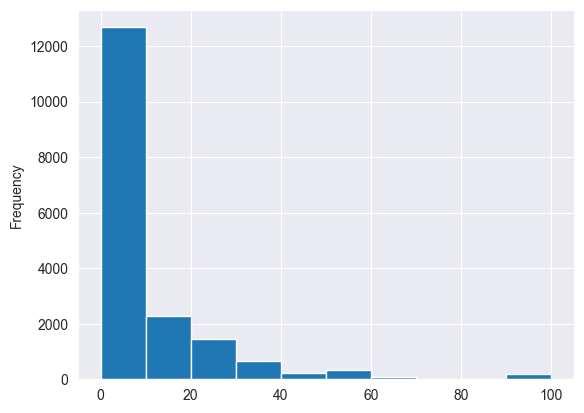

In [227]:
user_611334['winning_perc'].plot(kind='hist')

In [215]:
# Total count
total_count = user_611334['winning_perc'].count()

# Count where winning_perc > 7
greater_than_7_count = user_611334[user_611334['winning_perc'] > 7].shape[0]

# Percentage
percentage = (greater_than_7_count / total_count) * 100

print(f"{percentage:.2f}% of members have winning_perc > 7% on the lots where user 611334 placed bids.")


34.17% of members have winning_perc > 7% on the lots where user 611334 placed bids.


### For user 611334 :
1. The user placed bids on 56 different lots.
2. The user has a winning percentage of 7% on those lots.
3. The average maximum bid amount placed by the user is $9546 , and average selling price of those lots is $9925.
4. Total of 725 members placed bids on the same lots as user 611334 with a winning percentage of 9%.
5. The average maximum bid amount placed by these members is $5230 , and the average selling price of the lots won is $3034.
4. Approximately 35% of the members who placed bids on the same lots as user 611334 have a winning percentage greater than 7%.

* Second example

In [216]:
data2_copy[(data2_copy['winning_perc'] >= 20) & (data2_copy['mbr_country'] == 'USA')]

,owner_mbr_nbr,mbr_nbr,total_bids_on_lots_sold,total_lots_placed_bids_on,total_lots_won,avg_max_bid_amt,AvgSellingPrice,mbr_state,mbr_country,member_sgmnt_type,churn,winning_perc
2,569911,569911,419,103,27,2645.905622,2487.962963,KY,USA,Dealer,0,26.21
6,644723,644723,1304,327,83,3031.704400,3576.506024,TX,USA,Dismantler,0,25.38
11,593627,593627,1,1,1,2325.420077,2950.000000,MN,USA,Dismantler,0,100.00
21,794592,794592,348,61,32,6846.970346,7038.281250,FL,USA,Dealer,0,52.46
29,519980,519980,2519,481,127,2368.783724,2144.291339,MI,USA,Dealer,0,26.40
...,...,...,...,...,...,...,...,...,...,...,...,...
6332,52633,52633,24,1,1,3540.566038,4050.000000,NC,USA,Consumer,0,100.00
6334,556022,556022,20,2,1,1554.296375,5100.000000,TN,USA,Consumer,1,50.00
6343,804482,804482,34,8,4,2350.326797,3200.000000,NY,USA,Dealer,0,50.00
6364,177087,177087,76,14,4,5830.124373,9681.250000,NC,USA,Dealer,1,28.57


In [217]:
filtered_df_1 = data2_copy[(data2_copy['winning_perc'] >= 20) & (data2_copy['mbr_country'] == 'USA')]
filtered_df_1[filtered_df_1['owner_mbr_nbr'] == 793171]

,owner_mbr_nbr,mbr_nbr,total_bids_on_lots_sold,total_lots_placed_bids_on,total_lots_won,avg_max_bid_amt,AvgSellingPrice,mbr_state,mbr_country,member_sgmnt_type,churn,winning_perc
53,793171,793171,474,74,26,3988.626398,4418.230769,CO,USA,Dealer,0,35.14


In [218]:
query5 = """
WITH target_lots AS (
  SELECT DISTINCT b.lot_nbr
  FROM `cprtpr-dataplatform-sp1`.usviews.v_us_bids_fact b
  JOIN `cprtpr-dataplatform-sp1`.usviews.v_us_lot_fact l
    ON b.lot_nbr = l.lot_nbr
  WHERE b.buyer_nbr = 793171
    AND l.inv_dt BETWEEN '2024-10-01' AND '2025-03-31'
    AND l.seller_parent_company != 'CDS'
),

-- Step 2: Find all bids on those 8 lots by other buyers
other_bidders AS (
  SELECT
    b.lot_nbr,
    b.buyer_nbr,
    b.bid_amt,
    b.bid_dttm
  FROM `cprtpr-dataplatform-sp1`.usviews.v_us_bids_fact b
  JOIN target_lots tl
    ON b.lot_nbr = tl.lot_nbr
  WHERE b.buyer_nbr != 793171
)

-- Step 3: Optionally join member info for those other buyers
SELECT
  ob.lot_nbr,
  ob.buyer_nbr,
  m.owner_mbr_nbr,
  m.mbr_state,
  m.member_sgmnt_type,
  ob.bid_amt,
  ob.bid_dttm
FROM other_bidders ob
LEFT JOIN `cprtpr-dataplatform-sp1`.usviews.v_us_member_fact m
  ON ob.buyer_nbr = m.mbr_nbr
ORDER BY ob.lot_nbr, ob.bid_amt DESC
"""

data5 = client.query(query5).to_dataframe()

In [219]:
data5_copy = data5.copy()

In [220]:
mbr_lst_1 = data5_copy['owner_mbr_nbr'].unique().tolist()
user_793171 = data4_copy[data4_copy['owner_mbr_nbr'].isin(mbr_lst_1)]
user_793171

,owner_mbr_nbr,mbr_nbr,total_bids_on_lots_sold,total_lots_placed_bids_on,total_lots_won,avg_max_bid_amt,AvgSellingPrice,mbr_state,mbr_country,member_sgmnt_type,winning_perc
1105,388238,718365,98,21,2,5794.539889,6900.000000,OR,USA,Dismantler,9.52
1931,461837,602169,314,51,8,5539.569707,6287.500000,GE,GEO,Exporter,15.69
2684,191657,299970,0,0,0,3141.680881,0.000000,FL,USA,Dealer,0.00
6527,191657,871552,0,0,0,0.000000,0.000000,FL,USA,Dealer,0.00
7072,820921,820921,560,216,22,1337.628761,1744.318182,CH,MEX,Exporter,10.19
...,...,...,...,...,...,...,...,...,...,...,...
12741765,461837,249367,0,0,0,2531.873479,0.000000,GE,GEO,Exporter,0.00
12744665,388238,804173,101,9,2,5189.206471,8150.000000,OR,USA,Dismantler,22.22
12744863,461837,677218,848,109,1,1666.153513,2900.000000,GE,GEO,None,0.92
12745147,191657,164272,0,0,0,1119.535696,0.000000,FL,USA,Dealer,0.00


In [221]:
user_793171['owner_mbr_nbr'].nunique()

422

In [222]:
np.mean(user_793171['avg_max_bid_amt'])
np.mean(user_793171['AvgSellingPrice'])
np.mean(user_793171['winning_perc'])

np.float64(5361.395800397799)

np.float64(3664.2690158759456)

np.float64(10.603575779290578)

In [223]:
# Total count
total_count = user_793171['winning_perc'].count()

# Count where winning_perc > 7
greater_than_7_count = user_793171[user_793171['winning_perc'] > 35].shape[0]

# Percentage
percentage = (greater_than_7_count / total_count) * 100

print(f"{percentage:.2f}% of members have winning_perc > 35% on the lots where user user_793171 placed bids.")


6.08% of members have winning_perc > 35% on the lots where user user_793171 placed bids.


### For user 793171 :
1. The user placed bids on 74 different lots.
2. The user has a winning percentage of 35% on those lots.
3. The average maximum bid amount placed by the user is $3,988 , and average selling price of those lots is $4,418.
4. Total of 422 members placed bids on the same lots as user 793171 with a winning percentage of 10%.
5. The average maximum bid amount placed by these members is $5,361 , and the average selling price of the lots won is $3,664.
4. Approximately 6% of the members who placed bids on the same lots as user 793171 have a winning percentage greater than 35%.